In [484]:

# -------------------------- LIBRARIES NECESSARY IN THIS PROJECT  -------------------------- #

import numpy as np 
import pandas as pd 
import datetime as datetime
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# -------------------------- FUNCTIONS -------------------------- #

def getMeltedData(data_path,case_type):
    df_initial=pd.read_csv(data_path)
    melted_df=df_initial.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'])
    melted_df.rename(columns={"variable":"Date","value":case_type}, inplace = True)
    return melted_df

def getMergedData(df_confirmed,df_recovered,df_deaths):
    df_new=df_confirmed.join(df_recovered["Recovered"]).join(df_deaths["Deaths"])
    return df_new

def getCountryCode(data_path):

    # Loading Country codes in order to load merge with population data 
    df_countryCode=pd.read_csv(data_path)
    df_countryCode["Country"]=df_countryCode["Country"].astype(str)
    
    df_countryCode.sort_values("Country", inplace=True)
    df_countryCode.drop_duplicates(inplace=True)

    df_countryCode=df_countryCode.set_index("Country")

    return df_countryCode

def getPopulation(data_path):
    df_population_set2=pd.read_csv(data_path)
    df_population_set2=df_population_set2.melt(id_vars=["Country", "Country_Code"])
    df_population_set2.rename(columns={"variable":"YearOfPopulation","value":"Population"},inplace=True)
    df_population_set2=df_population_set2.replace({"YearOfPopulation": r"[^0-9]+"}, {"YearOfPopulation": ""}, regex=True)
    df_population_set2["YearOfPopulation"]=df_population_set2["YearOfPopulation"].astype(int)
    TheLatestYear=np.max(df_population_set2["YearOfPopulation"])
    df_population=df_population_set2[df_population_set2.YearOfPopulation==TheLatestYear]
    df_population=df_population.set_index("Country_Code")
    df_population.rename(columns={"Population":"Population"},inplace=True)
    df_population=df_population.drop(["YearOfPopulation"], axis = 1) 
    return df_population

# Get the files mergeded and merge them to become only one file
def getFullData(confirmed_file_path,recovered_file_path,deaths_file_path):
    # Get file with confirmed cases data
    confirmed_df=getMeltedData(confirmed_file_path,"Confirmed")

    # Get file with Recovered cases data
    recovered_df=getMeltedData(recovered_file_path,"Recovered")

    # Get file with Deaths cases data
    deaths_df=getMeltedData(deaths_file_path,"Deaths")

    # Merge the files
    full_df=getMergedData(confirmed_df,recovered_df,deaths_df)
    
    return full_df

confirmed_cases_path="data/time_series_19-covid-Confirmed.csv"
recovered_cases_path="data/time_series_19-covid-Recovered.csv"
deaths_cases_path="data/time_series_19-covid-Deaths.csv"
population_data_path="data/population-figures-by-country-csv_csv.csv"
countrycode_data_path="data/country_codes.csv"

## 1. Data manipulation and cleansing<a name="preparation"></a>

In this stage was chosen how we would work with data along with the assignment. Two options were given to us in order to have access to the data. In the first option, the dataset is structured in a way to present a new file every day with the number of confirmed cases, deaths and recovered in that day. And, the second option there are three separate files (time_series_19-covid-Confirmed.csv, time_series_19-covid-Deaths.csv and time_series_19-covid-Recovered.csv) one for each of the fields confirmed cases, deaths, recovered patients. Though a meeting the group decided to choose the second option. This option chosen presented a higher number of columns that increases with each update of the dataset, however, it is better is more suitable for efficient analysis. And so these files were uploaded. In order to ensure that the stored data are correct, consistent, complete and Adhering to business rules and established domains some changes were necessary on the original files. Firstly, the files were melted from the wide format (the data are structured in a way where each column corresponds to a variable) to long format (The data is structured where a single participant may occupy multiple rows) and then merged with the file which contains the code of each country. And so these files were merged becoming no longer three files and so one.

In [485]:
# Full Dataset Preparation
df=getFullData(confirmed_cases_path,recovered_cases_path,deaths_cases_path)

# Merge with file with country codes
df_countryCode=getCountryCode(countrycode_data_path)
df.rename(columns={'Country/Region':'Country'}, inplace = True)
df = df.join(df_countryCode, on="Country", how="left")

1.1 Data cleansing stage

In this stage, some columns are renamed to be easier used along with the project and other columns were removed from the file for being unnecessary (columns Lat and Long). Besides these changes, the value “Unknown” is updated in the column Region when this column is null valued and the field date is converted from the format MM/DD/YYYY to MM-DD-YYYY.
As the last update in this section, a column called Active is created in the file. This field represented the sum of active cases, which is calculated by the formula Confirmed- Recovered + Deaths. It was understood that this field would be often used in the project and so the creating of it would make easier to be used avoiding this value to be calculated all the time it is needed.



In [486]:
# Renaming columns
df.rename(columns={'Province/State':'Region', 'Country/Region':'Country'}, inplace = True)

# Dropping unnecessary columns
df=df.drop(["Lat","Long"], axis = 1) 

# Update the values for "Unknown" when the value in the columun is null
df["Region"].fillna("Unknown", inplace = True)

# Datatype conversion
df["Date"] = pd.to_datetime(pd.to_datetime(df["Date"]).dt.date)

# Creating of the column Active
df["Active"]=df["Confirmed"]-(df["Recovered"] + df["Deaths"])

## 2. Descriptive analysis and initial data exploration

This stage is the initial phase of studying and analyzing information, which the data are all summarized, organized and described using statistical metrics. As a result of the finding of this stage some questions such as How many countries have reported at least 10 cases? / Which are the five countries with the highest number of active cases? / What is the current rate of increase in the total number of cases, based on the last week of data? These questions are answered bellow.


### 2.1. How many countries have reported at least 10 cases? 

In [487]:
# Finds the number of countries at least 10 confirmed cases
max_date = np.max(df["Date"])
subset = df[df["Date"]==max_date].groupby("Country")["Confirmed"].sum().reset_index()

countriesAtleastTenCases = subset[subset["Confirmed"] >= 10]
numberOfCountriesAtleastTenCases = len(countriesAtleastTenCases)

print(str(numberOfCountriesAtleastTenCases) + " countries have reported at least 10 cases")


110 countries have reported at least 10 cases


### 2.2. Which are the five countries with the highest number of active cases?

In [488]:
# Finds the top 5 countries with the highest number of active cases
max_date=np.max(df["Date"])
subset=df[df["Date"]==max_date].groupby("Country")["Active"].sum().reset_index()
countriesTopFiveActiveCases=subset.sort_values("Active", ascending=False).head(5).set_index("Country").reset_index()
countriesTopFiveActiveCases.head()

,Country,Active
0,Italy,33190
1,Spain,16026
2,Germany,15163
3,US,13477
4,Iran,11413


### 2.3. What is the current rate of increase in the total number of cases, based on the last week of data?

In [489]:
df.sort_values(["Country_Code","Country", "Region","Date"], inplace = True)
df["DailyIncrease"] = df.groupby(["Country_Code","Country", "Region"])["Confirmed"].transform(lambda x: x.diff())
df["DailyIncrease"].fillna(0, inplace = True)
df["DailyIncrease"]=df["DailyIncrease"].astype(int)

subset=df.groupby("Date")["DailyIncrease"].sum().reset_index()
subset=subset.sort_values("Date", ascending=False).reset_index()

# Getting present full week
max_date=np.max(subset["Date"])

present_full_week=subset[subset["Date"]>(max_date+datetime.timedelta(days=-7))]
total_present=np.sum(present_full_week["DailyIncrease"])

# Getting past full week
past_full_week=subset[(subset["Date"] > (max_date+datetime.timedelta(days=-14))) & (subset["Date"]<=(max_date+datetime.timedelta(days=-7)))]
total_past=np.sum(past_full_week["DailyIncrease"])

# Current week growth rate presantage calculation
CurrentWeekGrowthRatePresentage=(((total_present-total_past)/total_past)*100).astype(int)

print("Current week growth rate peresentage:", str(CurrentWeekGrowthRatePresentage) + "%")


Current week growth rate peresentage: 275%


## 3. Data normalisation

The data is reported by country (and sometimes by state or province), as well as by date. This is a useful starting point, but this has two limitations, which is shown below.




### 3.1. Limitation 1
-  Not all countries have the same population. 5,000 cases in a country with 6 million inhabitants is not the same as 5,000 cases in a country with 95 million inhabitants. In order to have this limitation fixed the dataSet used so far is merged with a dataset file called population-figures-by-country-csv_csv.csv. This dataset contains the population by countries according to census and so the population taken from it was from 2016, which represents the population registered in the most recent census.

In [490]:
# Gets the population from the lastest sensus.
df_population = getPopulation(population_data_path)
# Joins population data
df_normalised = df.merge(df_population, on = ["Country","Country_Code"], how="left") 

### 3.2. Limitation 2
 - The outbreak did not start on the same day in every country. On any given day, one country might be at the peak of the outbreak, while in another community transmission is only just starting to occur. In order to fix this Limitation it was created in the file a column called Date0. This date which is grouped by country represents the first day which a country had more than 10 cases, and so all the data of the country before this date0 is ignored.

In [491]:
subset_day0 = df_normalised[df_normalised["Confirmed"]>=10].groupby(["Country","Country_Code"])["Date"].min().reset_index()
subset_day0.rename(columns={"Date" : "Day0"}, inplace=True)

# Avoiding column duplication issue and removing existing column if it exists. This is useful if you run this section again.
if set(["Day0"]).issubset(df_normalised.columns):
        df_normalised=df_normalised.drop(["Day0"], axis = 1)
# Merge the column first date with countries
df_normalised = df_normalised.merge(subset_day0, on=["Country","Country_Code"])
df_normalised = df_normalised[df_normalised["Date"] >= df_normalised["Day0"]]

## 4. Further data exploration

### 4.0 In order to carry out task 4, we need to calculate peak date of active cases. 

The stage of descriptive analysis and initial data exploration above represents just a brief summarized of the research. In order to more deeply answers about the Corona virus some were presented to us by this project. These questions are answered bellow. In order to answer these questions, a column named DatePeak is created, this represents the date which a country had his peak of the disease and it is largely used in this topic.


In [492]:

#df_normalised
# Retrieving daily active cases per country
subset = df_normalised.groupby(["Country","Country_Code","Date"])["Active"].sum().reset_index()

# Finding indices for peak active cases
indices = subset.groupby(["Country","Country_Code"])["Active"].idxmax()

# Finding peak dates with active cases
subset = subset.loc[indices].sort_index()

subset.rename(columns={"Date":"DatePeak","Active":"ActivePeak"}, inplace=True)

df_4_0 = df_normalised.merge(subset, on=["Country_Code","Country"], how="left")

###  4.1 Which regions or countries seem to have passed the peak of their local outbreak?

Some countries seem to have passed their local outbreak. In order to get these countries as shown by the result of this query. This result was obtained by checking the countries which the peak date occurred before the last date of the file. It means that the countries bellow the number of the confirmed case supposed to have already reached the peak and so the number of new cases seems to be decreasing by the time.

In [493]:
# Finding countries that seemed to have passed the peak of local outbreak
subset_4_1 = df_4_0[df_4_0["DatePeak"] < np.max(df_4_0["Date"])].groupby(["Country","Country_Code","Day0","DatePeak"])["ActivePeak"].first().reset_index()
subset_4_1


,Country,Country_Code,Day0,DatePeak,ActivePeak
0,Afghanistan,AFG,2020-03-14,2020-03-17,21
1,Algeria,DZA,2020-03-04,2020-03-18,55
2,Belarus,BLR,2020-03-12,2020-03-18,46
3,Bolivia,BOL,2020-03-14,2020-03-18,12
4,Chile,CHL,2020-03-10,2020-03-18,238
5,China,CHN,2020-01-22,2020-02-17,58108
6,Cruise Ship,999,2020-02-07,2020-02-26,691
7,Greece,GRC,2020-03-05,2020-03-18,405
8,"Korea, South",KOR,2020-01-31,2020-03-15,7577
9,Liechtenstein,LIE,2020-03-18,2020-03-18,28


###  4.2 What can you say about how long it takes for the outbreak to peak?

As mentioned above the outbreak did not start on the same day in every country, and so it is as fact that the interval between the day0 and the date of peak vary by country as showed bellow. 





In [494]:
# Resolution
subSet4_2 = subset_4_1.copy()
subSet4_2["OutbreakToPeak"] = subSet4_2["DatePeak"] - subSet4_2["Day0"]
subSet4_2 = subSet4_2.sort_values("OutbreakToPeak", ascending = False)
subSet4_2

,Country,Country_Code,Day0,DatePeak,ActivePeak,OutbreakToPeak
8,"Korea, South",KOR,2020-01-31,2020-03-15,7577,44 days
5,China,CHN,2020-01-22,2020-02-17,58108,26 days
6,Cruise Ship,999,2020-02-07,2020-02-26,691,19 days
12,San Marino,SMR,2020-03-03,2020-03-18,104,15 days
1,Algeria,DZA,2020-03-04,2020-03-18,55,14 days
7,Greece,GRC,2020-03-05,2020-03-18,405,13 days
4,Chile,CHL,2020-03-10,2020-03-18,238,8 days
2,Belarus,BLR,2020-03-12,2020-03-18,46,6 days
13,Senegal,SEN,2020-03-13,2020-03-18,29,5 days
3,Bolivia,BOL,2020-03-14,2020-03-18,12,4 days


### 4.3. The dataset does not contain any information at the level of individual cases. However, based on the available data, can you estimate how long it takes patient to recover?  / Does this vary by region or country? / How confident can you be about these results?
A way to calculate the patient's recovery duration is to calculate the duration between first confirmed case date and first recovered case date. As mentioned above a column Day0 already exists and so what it is needed is something called Day0_recovered, which represents the first day a patient supposse to get recovered. As for the date0 is considered the first day a country has ten or more cases this rule will also be applied for Day0_recovered.

In [495]:
# Create column Day0_recovered
subSet4_3 = df_4_0.copy()
subset_day0_recovered = subSet4_3[subSet4_3["Recovered"] >= 10].groupby(["Country","Country_Code"])["Date"].min().reset_index()
subset_day0_recovered.rename(columns={"Date" : "Day0_recovered"}, inplace=True)
subset_day0_recovered.set_index(["Country","Country_Code"])
subSet4_3 = subSet4_3.merge(subset_day0_recovered, on = ["Country","Country_Code"])


Once we have the field Day0_recovered it is possible so to calculate the average time a patient recovers

In [496]:
# Calculation of average patient's recovery days per country
subSet4_3 = subSet4_3.groupby(["Country", "Country_Code", "Date", "Day0", "Day0_recovered", "DatePeak", "ActivePeak", "Population"])[["Confirmed", "Recovered", "Deaths", "Active"]].sum().reset_index()

subSet4_3["PatientRecoveredDays"] = (subSet4_3["Day0_recovered"] - subSet4_3["Day0"]).astype('timedelta64[D]').astype(int)

AveragePatientRecoveredDuration = np.mean(subSet4_3[(subSet4_3["PatientRecoveredDays"]!=0)]["PatientRecoveredDays"])

print("A patient takes average " + str(int(AveragePatientRecoveredDuration)) + " days to get recovered.")


A patient takes average 13 days to get recovered.


###  4.4 Can you say anything about the effectiveness of mitigation strategies?

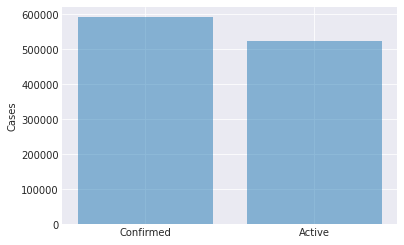

In [497]:
# Finding countries that are not seemed to have passed the peak of local outbreak
subset_4_4 = subSet4_3[subSet4_3["DatePeak"]==np.max(subSet4_3["Date"])].groupby(["Country","DatePeak","Population"])["Confirmed","Recovered","Deaths","Active"].sum().reset_index()

subset_4_4=subset_4_4.groupby("DatePeak")["Confirmed","Active"].sum().reset_index()
subset_4_4

# In order to analyse, we need to normalize confirmed case.

confirmed_value=np.sum(subset_4_4["Confirmed"])
active_value=np.sum(subset_4_4["Active"])
objects = ('Confirmed', 'Active')
y_pos = np.arange(len(objects))
performance = [confirmed_value,active_value]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Cases')

plt.show()

In [498]:
# Continue to analyse
# To address effectiveness of mitigation strategies, the country which discovered in task 4.2 should be used. This means achieving this task with countries which have already reached their peaks is crucial. So below is filtering full dataset by countries that reached the peak.
subSet_temp=subSet4_2.copy()
subset_4_4=df_4_0.copy()
subSet_temp=subSet_temp[["Country","Country_Code"]]
subset_4_4=subset_4_4.merge(subSet_temp, on=["Country","Country_Code"], how="inner")
subset_4_4

# Data that passed the peak period needs to be considered

subset_4_4=subset_4_4[(subset_4_4["DatePeak"]<subset_4_4["Date"])]
subset_4_4

# In order to discover the effectiveness of recovery, the ratio between patient's recovery and deaths may show the reduction of active cases that are really caused by patient's recovery or deaths. If the ratio is low, it can be considered 

subset_4_4=subset_4_4.groupby(["Country","Country_Code","Date","DatePeak"])["Confirmed","Recovered","Deaths","Active"].sum().reset_index()
subset_4_4["RatioBetweenRecoveredVsDeaths"]=subset_4_4["Deaths"] /subset_4_4["Recovered"]
subset_4_4["RatioBetweenRecoveredVsDeaths"].fillna(0, inplace = True)

subset_4_4["FlattenDaysSinceStarted"]=(subset_4_4["Date"] - subset_4_4["DatePeak"]).astype('timedelta64[D]').astype(int)
subset_4_4.sort_values("RatioBetweenRecoveredVsDeaths", ascending=False)
#subset_4_4=subset_4_4[(subset_4_4["RatioBetweenRecoveredVsDeaths"]>0) & (subset_4_4["RatioBetweenRecoveredVsDeaths"]<1)]
subset_4_4

#fig = go.Figure(data=go.Scatter(x=subset_4_4["FlattenDaysSinceStarted"], y=subset_4_4["RatioBetweenRecoveredVsDeaths"],mode='lines+markers',name='lines+markers'))
fig = px.line(subset_4_4, x="FlattenDaysSinceStarted", y="RatioBetweenRecoveredVsDeaths", color="Country", hover_name="Country",line_shape="spline", render_mode="svg")
fig.update_layout(autosize=True,width=1000,height=500,yaxis=dict(title_text="Ratio between Recovered vs Deaths",tickmode="array"),xaxis=dict(title_text="Days since started flattening",tickmode="array"))
fig.show()


###  4.5 In epidemiology, the case fatality rate (CFR) is the ratio of deaths from a certain disease to the total number of people diagnosed with this disease. The formula is straight-foward once an epidemic has ended. However, while an epidemic is still ongoing, as it is the case with the COVID-19 outbreak, this formula can be "misleading if, at the time of analysis, the outcome is unknown for a non negligible proportion of patients."1 One alternative is to estimate CFR as deaths / (deaths + recovered). What kind of assumptions is that making? If you use this formula, what range of values do you get? Does this vary over time?

In [499]:
# Calculating CFR to everyday for country
subSet4_5 = df_4_0.copy()
subSet4_5 = subSet4_5.groupby(["Country","Date","Day0","Population"])["Confirmed","Recovered","Deaths"].sum().reset_index()
subSet4_5["CFR"] = subSet4_5["Deaths"] / (subSet4_5["Deaths"] + subSet4_5["Recovered"])
subSet4_5["CFR"].fillna(0, inplace = True)


After the CFR be calculated by country is possible to make some assumptions as described bellow.

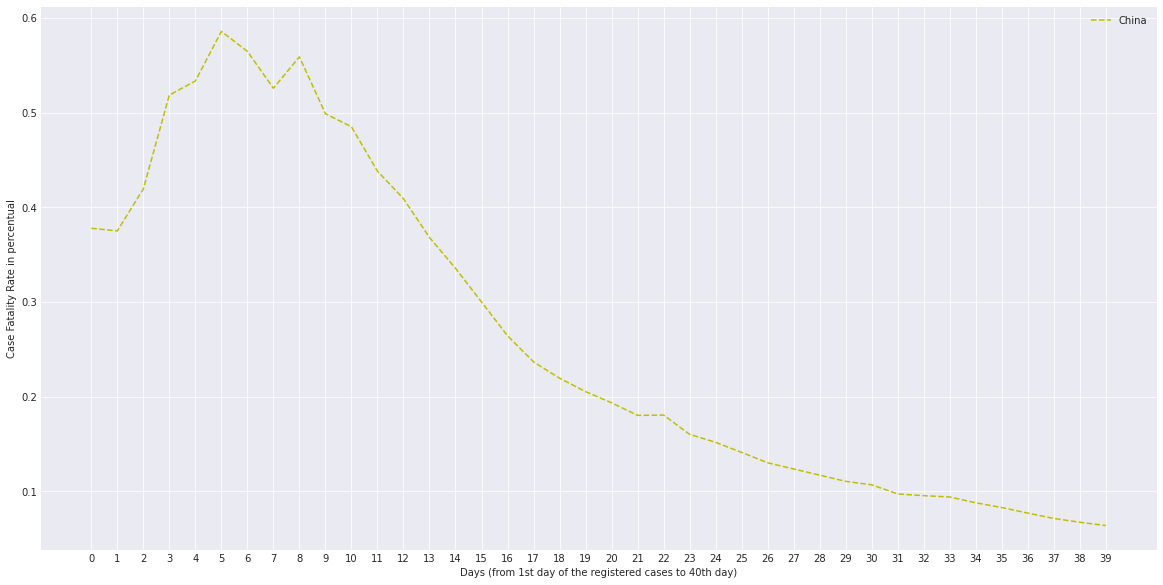

In [500]:
# Plot a CFR for China
china = subSet4_5[(subSet4_5["Country"] == "China")].sort_values("Date").reset_index().head(40)
china = china[["Date","CFR"]]
china["CFR"].fillna(0,inplace=True)

plt.figure(figsize = (20,10))
plt.xticks(china.index.values)
plt.plot(china.index.values,china["CFR"], 'y--')

plt.legend(["China"])
plt.xlabel('Days (from 1st day of the registered cases to 40th day)')
plt.ylabel('Case Fatality Rate in percentual')
plt.plot()
plt.show()

For example, China is the first country where the case of Corona virus was registered. For this country the deaths started already in the second of the registred cases, reaching the peak (from day 0 to 40) after 4 days. The rate of deaths went day from day 7 to 8 to start growing again until day 12th when the rate of deaths started to decrease.

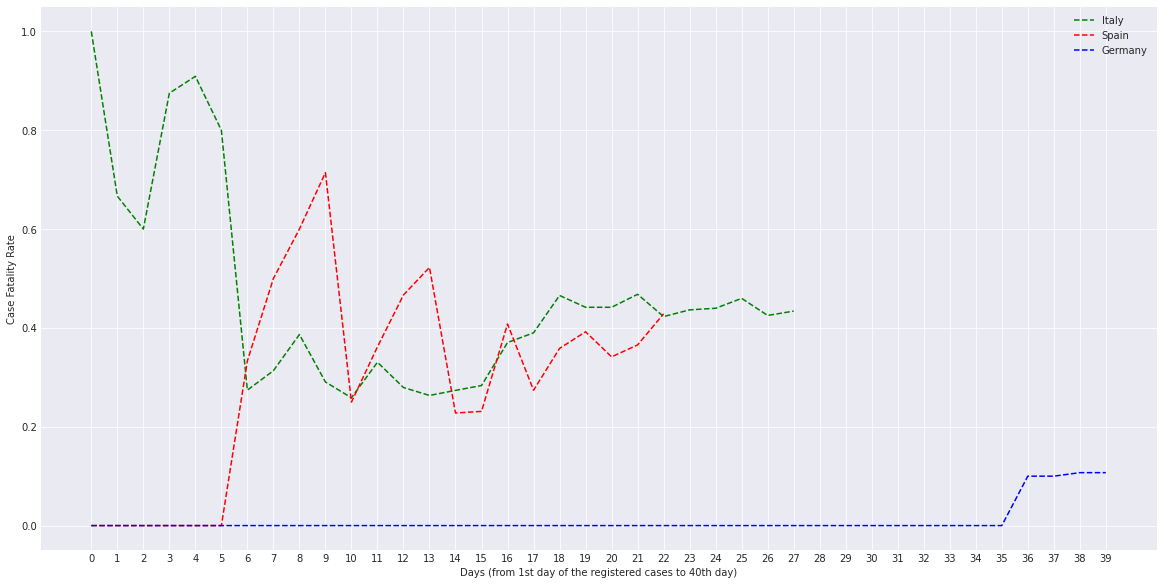

In [501]:

Italy = subSet4_5[(subSet4_5["Country"] == "Italy")].sort_values("Date").reset_index().head(40)
Italy = Italy[["Date", "CFR"]]
Italy["CFR"].fillna(0,inplace=True)

Spain = subSet4_5[(subSet4_5["Country"]=="Spain")].sort_values("Date").reset_index().head(40)
Spain = Spain[["Date", "CFR"]]
Spain["CFR"].fillna(0,inplace=True)

Germany = subSet4_5[(subSet4_5["Country"]=="Germany")].sort_values("Date").reset_index().head(40)
Germany  =Germany[["Date", "CFR"]]
Germany["CFR"].fillna(0,inplace=True)

plt.figure(figsize=(20,10))
plt.xticks(Germany.index.values)
plt.plot(Italy.index.values,Italy["CFR"], 'g--',Spain.index.values,Spain["CFR"], 'r--',Germany.index.values,Germany["CFR"], 'b--')

plt.legend(["Italy", "Spain","Germany"])
plt.xlabel('Days (from 1st day of the registered cases to 40th day)')
plt.ylabel('Case Fatality Rate')
plt.plot()
plt.show()


Italy, Spain and Germany were the countries with the highest active cases by that time and why they were chosen to be studied. These countries represented differences in their deaths rates. Italy represented a high rate of death from day 2 until 5 and reached a maximum of 0.7 amost in 20th day. Spain had his first death on the 5th day and reached a peak in the 8th day with 0.7, after this the maximum reached in Spain was 0.5. Germany, however, the deaths started occurring just in the 35th day.

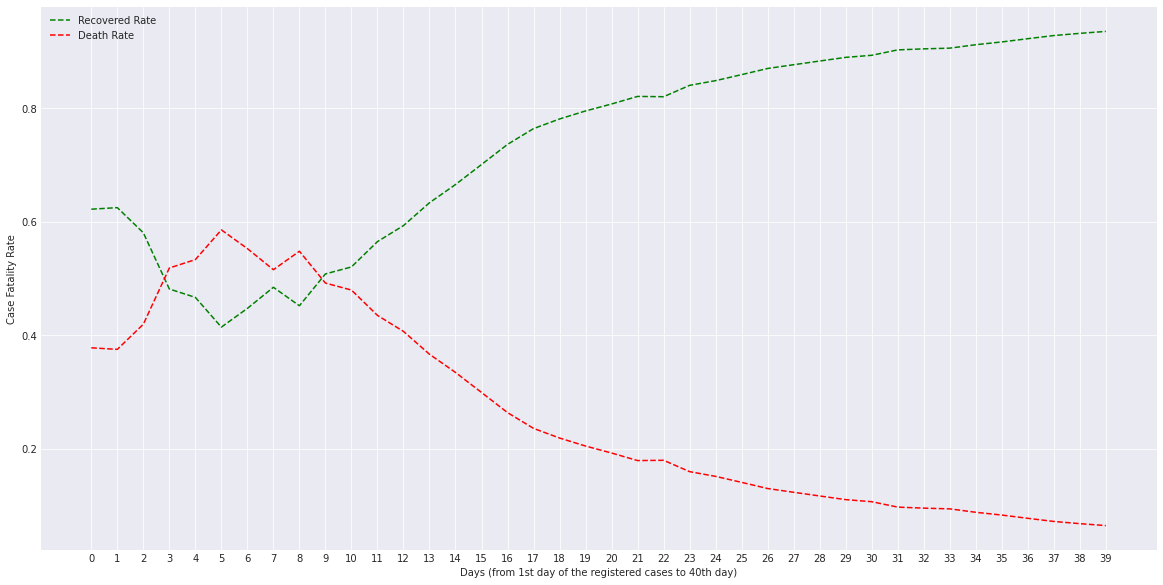

In [502]:
# Precent of recovered
worldwide_4_5 = subSet4_5.groupby(["Date"])["Recovered", "Deaths"].sum().reset_index()
worldwide_4_5["CFR"] = worldwide_4_5["Deaths"]/(worldwide_4_5["Deaths"] + worldwide_4_5["Recovered"])
worldwide_4_5["CFR"] = worldwide_4_5["CFR"]

worldwide_4_5["RecoveredRates"] = worldwide_4_5["Recovered"] / (worldwide_4_5["Deaths"] + worldwide_4_5["Recovered"])
worldwide_4_5["RecoveredRates"]  = worldwide_4_5["RecoveredRates"]

worldwide_4_5["RecoveredRates"].fillna(0,inplace=True)
worldwide_4_5=worldwide_4_5.sort_values("Date").head(40)
worldwide_4_5

plt.figure(figsize=(20,10))
plt.xticks(worldwide_4_5.index.values)
plt.plot(worldwide_4_5.index.values,worldwide_4_5["RecoveredRates"], 'g--',worldwide_4_5.index.values,worldwide_4_5["CFR"], 'r--')

plt.legend(["Recovered Rate", "Death Rate"])
plt.xlabel('Days (from 1st day of the registered cases to 40th day)')
plt.ylabel('Case Fatality Rate')
plt.plot()
plt.show()

The graphic above represented a comparison between a recovered rate and death rate worldwide, and fortunately, it concluded that people are recovered more than die in the world from the 1th to 40th which Corona virus was confirmed in the world.

###  4.6 With a disease like COVID-19 where the vast majority of cases are mild or even asymptomatic, the number of confirmed cases is going to be highly dependent on the testing strategy. Do you see any relationship between the number of cases and your estimated CFR values?

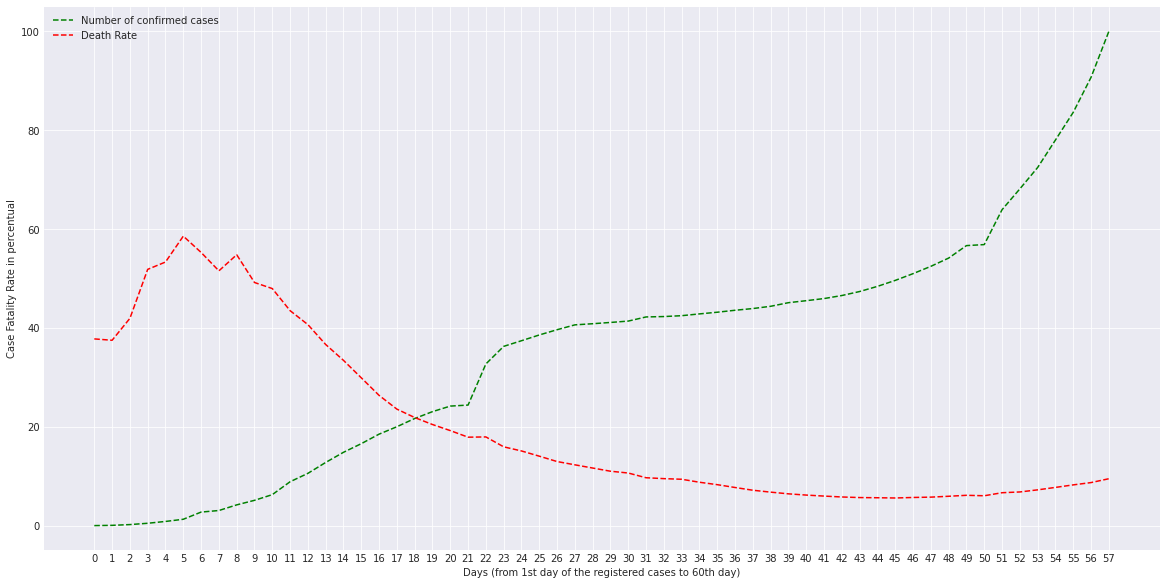

In [503]:
# Resolution

worldwide_4_6 = subSet4_3.copy()
worldwide_4_6 = worldwide_4_6.groupby(["Date"])["Confirmed","Recovered","Deaths"].sum().reset_index()
worldwide_4_6["CFR"] = worldwide_4_6["Deaths"] / (worldwide_4_6["Deaths"]+worldwide_4_6["Recovered"])
worldwide_4_6 = worldwide_4_6.sort_values("Date")
worldwide_4_6

# In order to compare confirmed cases against CFR, we need to normalize confirmed case.
min_value = np.min(worldwide_4_6["Confirmed"])
max_value = np.max(worldwide_4_6["Confirmed"])

new_min = 0
new_max = 100

normalised_confirmed = (worldwide_4_6["Confirmed"] - min_value) / (max_value-min_value) * (new_max-new_min) + new_min
worldwide_4_6["normalised_Confirmed"]=normalised_confirmed

# In order to compare confirmed cases against CFR, we need to normalize CFR.
worldwide_4_6["normalised_CFR"] = worldwide_4_6["CFR"] * 100

worldwide_4_6

plt.figure(figsize=(20,10))
plt.xticks(worldwide_4_6.index.values)
plt.plot(worldwide_4_6.index.values,worldwide_4_6["normalised_Confirmed"], 'g--', worldwide_4_6.index.values,worldwide_4_6["normalised_CFR"], 'r--')

plt.legend(["Number of confirmed cases", "Death Rate"])
plt.xlabel('Days (from 1st day of the registered cases to 60th day)')
plt.ylabel('Case Fatality Rate in percentual')

plt.plot()
plt.show()


Analyzing the first 10 days of the disease around the world it is possible to say that the number of death rate was really high and increased as the Confirmed cases, maybe because the world still did not know how to deal with the Virus yet. After the 20th day however the number of confirmed case and death rate were distinct. As the CFR started to decrease by the time compared to the confirmed cases.

## 5. Data visualisation

### 5.1 The graph below shows the progression of the virus for the countries which presented 50 or more cases in the first month of the first confirmed case.

In [508]:
# Resolution
subset_5_1=df_normalised.copy()
subset_5_1=subset_5_1.groupby(["Country","Country_Code","Date","Day0"])["Confirmed"].sum().reset_index()

# Countries at least 50 confirmed cases
subset_5_1_country=subset_5_1[(subset_5_1["Date"]==np.max(subset_5_1["Date"])) & (subset_5_1["Confirmed"]>=50)]

subset_5_1_country=subset_5_1_country[["Country","Country_Code"]]
subset_5_1_country

subset_5_1=df_normalised.merge(subset_5_1_country, on=["Country","Country_Code"], how="inner")
subset_5_1
subset_5_1["DaySinceCasesStarted"]=(subset_5_1["Date"]-subset_5_1["Day0"]).astype('timedelta64[D]').astype(int)
subset_5_1=subset_5_1.groupby(["Country","Country_Code","Date","Day0","DaySinceCasesStarted"])["Confirmed"].sum().reset_index()
subset_5_1=subset_5_1[subset_5_1["DaySinceCasesStarted"]>=0]
Countrylist=subset_5_1_country["Country"].values.tolist()
countries = list(dict.fromkeys(Countrylist))
#print(countries)
subset_5_1

,Country,Country_Code,Date,Day0,DaySinceCasesStarted,Confirmed
0,Albania,ALB,2020-03-10,2020-03-10,0,10
1,Albania,ALB,2020-03-11,2020-03-10,1,12
2,Albania,ALB,2020-03-12,2020-03-10,2,23
3,Albania,ALB,2020-03-13,2020-03-10,3,33
4,Albania,ALB,2020-03-14,2020-03-10,4,38
...,...,...,...,...,...,...
1476,Vietnam,VNM,2020-03-15,2020-02-06,38,56
1477,Vietnam,VNM,2020-03-16,2020-02-06,39,61
1478,Vietnam,VNM,2020-03-17,2020-02-06,40,66
1479,Vietnam,VNM,2020-03-18,2020-02-06,41,75


In [509]:
# Visualisation
fig = px.line(subset_5_1, x="DaySinceCasesStarted", y="Confirmed", color="Country", hover_name="Country",line_shape="spline", render_mode="svg")
fig.update_layout()
fig.update_layout(autosize=True,width=1000,height=500,yaxis=dict(title_text="Confirmed cases",tickmode="array",type="linear"),xaxis=dict(title_text="Days since cases started",tickmode="array"))
fig.show()

fig.update_layout(autosize=True,width=1000,height=500,yaxis=dict(title_text="Confirmed cases",tickmode="array",type="log"),xaxis=dict(title_text="Days since cases started",tickmode="array"))
fig.show()

### 5.2

In [482]:
subSet5_1 = df_normalised.copy()
subSet5_1 = subSet5_1.groupby(["Country", "Date", "Day0"])["Confirmed", "Recovered", "Deaths", "Active"].sum().reset_index()

subSet5_1["Week_Of_a_Date"] = subSet5_1["Date"].dt.week
subSet5_1 = subSet5_1.groupby(["Country", "Week_Of_a_Date", "Day0"])["Confirmed", "Recovered", "Deaths", "Active"].sum().reset_index()

subSet5_1 = subSet5_1.groupby(['Week_Of_a_Date','Country']).sum().reset_index()
subSet5_1 = subSet5_1[(subSet5_1["Week_Of_a_Date"] <= 9)].sort_values(["Week_Of_a_Date", "Country"]).reset_index()


subSet5_1

# Creating the visualization
fig = px.choropleth(subSet5_1, 
                    locations="Country", 
                    locationmode = "country names",
                    color="Confirmed", 
                    hover_name="Country", 
                    animation_frame="Week_Of_a_Date"
                   )

fig.update_layout(
    title_text = 'Global Spread of Coronavirus',
    title_x = 0.5,
    geo=dict(
        showframe = True,
        showcoastlines = True,
    ))
    
fig.show()

 #['ISO-3', 'USA-states', 'country names', 'geojson-id']

# Creating the visualization


#subSet5_1["Week_Of_a_Date"] = (np.max(subSet5_1["Week_Of_a_Date"]) - subSet5_1["Week_Of_a_Date"]) +1

#subSet5_1.sort_values(["Day0", "Week_Of_a_Date", "Country"])

#subSet5_1.sort_values(["Week_Of_a_Date", "Country"])

#subSet5_1.head(60)


#subSet5_1.head(5)


